# Project - Machine Learning:  Predicting Bike Rentals with Model Ensembles  (Linear Regression, Decision Trees, Random Forests)

**Background and Aim**

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we'll create a few different machine learning models including liner regression, decision trees and random forests, and evaluate their performance.

### Dataset

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. We can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 
The dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.
Here are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [2]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")

In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


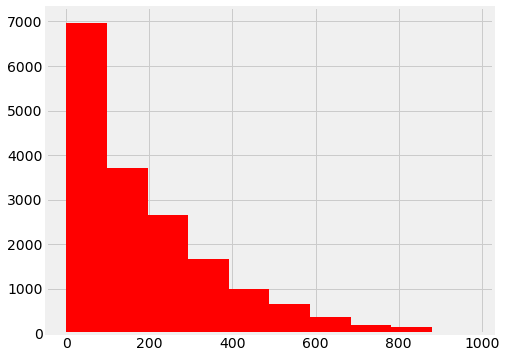

In [5]:
### Make Histogram of `cnt` column

fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
plt.hist(bike_rentals["cnt"], color='red')
plt.show()

In [6]:
# Determine correlation between `cnt` and various features
# Using corr() automatically excludes non-numeric columns

bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

### Calculating Features

It will be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

The `hr` column in `bike_rentals`, for instance, contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

Below, we will:
Write a function called `assign_label` that takes in a numeric value for an hour, and returns:
- `1` if the hour is from `6` to `12`
- `2` if the hour is from `12` to `18`
- `3` if the hour is from `18` to `24`
- `4` if the hour is from `0` to `6`
Use the `apply` method on series objects to apply the function to each item in the hr column.
Assign the result to the `time_label` column of bike_rentals

In [7]:
def assign_label(hour):
    ''' 1 = morning; 2 = afternoon; 3 = evening; 4 = night'''
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

In [8]:
# Apply function
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

### Splitting Dataset into training and testing sets
We will:
- Select 80% of the rows in `bike_rentals` to be part of the training set using the `sample` method on `bike_rentals` and assign the result to `train`.
- Select the rows that are in `bike_rentals` but not in `train` to be in the testing set and assign the result to `test`.

We will use the function isin() to separate the two sets:
- This line will generate a Boolean series that's False when a row in `bike_rentals` isn't found in `train`: `bike_rentals.index.isin(train.index)`
- This line will select any rows in `bike_rentals` that aren't found in `train` to be in the testing set: `bike_rentals.loc[~bike_rentals.index.isin(train.index)]`

In [9]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Error Metric
We will use mean squared error (MSE) as the error metric, which works well for continuous variables and fits our data well. 

### Applying Linear Regression

Linear regression should work fairly well on this data, given that many of the columns are highly correlated with `cnt`.And linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We'll ignore the `casual` and `registered` columns because `cnt` is derived from them. We will also exclude `dteday` column as it is not a numeric column and also makes the data overly repetitious as each day is treated differently from the other. 

In [10]:
# Remove unwanted columns from the dataset
predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

In [11]:
# Apply Linear Regression
from sklearn.linear_model import LinearRegression
rntls = LinearRegression()

rntls.fit(train[predictors], train["cnt"])

predictions = rntls.predict(test[predictors])

In [12]:
from sklearn.metrics import mean_squared_error
lr_mse = mean_squared_error(predictions, test['cnt'])
lr_mse

17910.058739423686

### Linear Regression Error
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Applying Decision Trees
Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

We can experiment with various parameters such as `depth` and `min_samples_leaf`. For this project, we will use `min_samples_leaf` = 5

In [13]:
# Predict for test set using decision trees algorithm
from sklearn.tree import DecisionTreeRegressor

rntls = DecisionTreeRegressor(min_samples_leaf=5)

rntls.fit(train[predictors], train["cnt"])

predictions = rntls.predict(test[predictors])

In [14]:
# Error metrics
dt_mse = mean_squared_error(predictions, test['cnt'])
dt_mse


2472.8224087434137

### Decion Tree Error
Decision tree error
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### Applying Random Forests

now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

We can experiment with various parameters such as `depth` and `min_samples_leaf`. For this project, we will use `min_samples_leaf` = 5, and keep `n_estimators` at the default of `100` trees. 

In [15]:
from sklearn.ensemble import RandomForestRegressor

rntls = RandomForestRegressor(n_estimators = 100, min_samples_leaf=5)
rntls.fit(train[predictors], train["cnt"])
predictions = rntls.predict(test[predictors])

In [16]:
# Error metrics
rf_mse = mean_squared_error(predictions, test['cnt'])
rf_mse

1602.2194476790592

### Random Forests Error
Random Forests error is a considerable improvement over both linear regression as well as the single decision tree as it gets rid of some of the sources of overfitting. 